# Context-Aware Complex Word Identification
Here we devise and implement all the relevant methods for evaluating the influence of context words for the complexity of a given target word. Thus, we implement various context definition methods that extract context words for a target based on different ideas (e.g. local context, grammatical context and semantic context). Afterwards we compute features for the context and use these features to represent the context in the classification task.

## 1. Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.wsd import lesk
import nltk

In [3]:
from collections import namedtuple
from collections import defaultdict

Model = namedtuple('Model', 'type, name, dimension, corpus, model')
Dataset = namedtuple('Dataset', 'name, train, test')
FeatureDataset = namedtuple('FeatureDataset', 'name, fc, agg, train, test')
FeatureCategory = namedtuple('FeatureCategory', 'name, func')
Aggregation = namedtuple('Aggregation', 'name, agg')

In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)
MAIN_PATH_DATASET = "../cwishareddataset/traindevset/english/"
genres = ['Wikipedia', 'WikiNews', 'News']
datasets = ['Train', 'Dev']

datasets = [Dataset('Wikipedia', 'Train_Feat', 'Dev_Feat'),
            Dataset('WikiNews', 'Train_Feat', 'Dev_Feat'),
            Dataset('News', 'Train_Feat', 'Dev_Feat')]

feature_categories = []

def load_df(path):
    df = pd.read_csv(path, header=0, sep = "\t")
    df = df.drop(['Unnamed: 0'], axis = 1)
    return df

datasets = [Dataset(d.name, load_df(MAIN_PATH_DATASET + d.name + '_' + d.train + '.tsv'),
                            load_df(MAIN_PATH_DATASET + d.name + '_' + d.test + '.tsv'))
                            for d in datasets]

## 2.1 Preprocessing

In [5]:
from nltk.stem.wordnet import *
from nltk import word_tokenize
from functools import lru_cache
from utils import penn_to_wn
import re
import unicodedata
import sys

wordNetLemmatizer = WordNetLemmatizer()

def overlaps(start1, end1, start2, end2):
    return bool(range(max(start1, start2), min(end1, end2)+1))

tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))

def remove_punctuation(text):
    return text.translate(tbl)

@lru_cache(maxsize=None)
def targets_with_index(start, end, context):
    curr_pos = 0
    targets = []
    j = 0
    w = 0
    curr_split = ''
    ctx_split = context.split()
    whitespaces = re.findall('\s+', context)
    num_whitespaces = [len(token) for token in whitespaces]
    num_whitespaces.append(1)
    tokens = word_tokenize(context)
    tokens = ['"' if token not in context else token for token in tokens]
    for index, token in enumerate(tokens, 1):
        targets.append((token, index, curr_pos, (curr_pos + len(token))))
        curr_pos += len(token)
        curr_split += token
        if ctx_split[j] == curr_split:
            curr_pos += num_whitespaces[w]
            j += 1
            w += 1
            curr_split = ''
    vals = [(target[0], target[1]) for target in targets \
            if overlaps(start, end, target[2], target[3])]
    return [val for val in vals if val[0] != '"']

@lru_cache(maxsize=None)
def wordnet_pos_tagging(sentence):
    tokens = word_tokenize(sentence)
    return nltk.pos_tag(tokens)

def pos_tags(start, end, sentence):
    wordPOSPairs = wordnet_pos_tagging(sentence)
    targets_index = targets_with_index(start, end, sentence)
    results = [wordPOSPairs[tpl[1]-1][1] for tpl in targets_index]
    filtered_results = [result for result in results 
                        if remove_punctuation(result).strip() and result != 'POS']
    return filtered_results if len(filtered_results) > 0 else None

def wordnet_lemma(target, pos):
    tokens = nltk.word_tokenize(target)
    if pos:
        pos = [penn_to_wn(poss) if penn_to_wn(poss) else 'n' for poss in pos]
        lemmas = [wordNetLemmatizer.lemmatize(token, poss)
                     for token, poss in zip(tokens, pos)]
        return ' '.join(lemmas)
    return target

def preprocessing(dataframe):
    df = dataframe.copy()
    df['p_sentence'] = df.sentence.apply(lambda sent : sent.strip().lower())
    df['sentence'] = df.sentence.apply(lambda sent : sent.replace("''", "``"))
    df['p_target'] = df.target.apply(lambda target : target.strip().lower())
    df['pos_tags'] = df[['start', 'end', 'sentence']].apply(lambda vals : pos_tags(*vals), axis = 1)
    df['pos_tags_pt'] = df.pos_tags.apply(lambda pos : [penn_to_wn(poss) if penn_to_wn(poss) else 'n' for poss in pos])
    df['lemma'] = df[['target', 'pos_tags']].apply(lambda vals : wordnet_lemma(*vals), axis = 1)
    df['p_lemma'] = df.lemma.apply(lambda lemma : lemma.strip().lower())
    return df

In [6]:
preprocessed_datasets = [Dataset(ds.name, preprocessing(ds.train), 
                               preprocessing(ds.test)) for ds in datasets]

In [7]:
datasets = preprocessed_datasets

## 2.2 Context-Token Aggregation
First we define how feature values of multiple context-tokens should be aggreagated.

In [8]:
word_freq_wiki = {}
sum_counts = 0
with open("resources/word-freq-dumps/enwiki-20150602-words-frequency.txt", encoding="utf8") as file:
    for line in file:
        word, freq = line.partition(" ")[::2]
        sum_counts+=int(freq)
        word_freq_wiki[word.strip()] = int(freq)
        
def get_unigram_probability(word):
    return word_freq_wiki.get(word,1) / (sum_counts + len(word_freq_wiki))

In [9]:
from nltk.tokenize import word_tokenize

def agg_ctx_feat_num_average(tokens, func_feature, *args, **kwargs):
    if all(isinstance(tpl, tuple) for tpl in tokens):
        return np.mean([func_feature(token, *args) for token, dist in tokens])
    return np.mean([func_feature(token, *args) for token in tokens])

def agg_ctx_feat_num_weighted_average(tokens, func_feature, alpha, *args):
    if all(isinstance(tpl, tuple) for tpl in tokens):
        if len(tokens)==1:
            return np.mean([func_feature(token, *args) for token, dist in tokens])
        prob_sum = np.sum([(alpha/(alpha+get_unigram_probability(token))) for token, dist in tokens])
        return np.mean([((alpha/(alpha+get_unigram_probability(token)))/prob_sum) * 
                func_feature(token, *args) for token, dist in tokens])
    prob_sum = np.sum([(alpha/(alpha+get_unigram_probability(token))) for token in tokens])
    return np.mean([((alpha/(alpha+get_unigram_probability(token)))/prob_sum) * 
                func_feature(token, *args) for token in tokens])

agg_feat_num_weighted_average_medium = lambda target, func_feature, *args: \
                        agg_ctx_feat_num_weighted_average(target, func_feature, 0.0001, *args)

def agg_ctx_feat_num_distance(tokens, func_feature, *args):
    if all(isinstance(tpl, tuple) for tpl in tokens):
        if len(tokens)==1:
            return np.mean([func_feature(token, *args) for token, dist in tokens])
        dist_sum = np.sum(dist for token, dist in tokens)
        return np.sum([(func_feature(token, *args) * ((dist_sum-dist)/dist_sum)) 
                    for token, dist in tokens])
    return np.mean([func_feature(token, *args) for token in tokens])

def agg_ctx_feat_num_median(tokens, func_feature, *args):
    if all(isinstance(tpl, tuple) for tpl in tokens):
        return np.median([func_feature(token, *args) for token, dist in tokens])
    return np.median([func_feature(token, *args) for token in tokens])

def agg_ctx_feat_num_max(tokens, func_feature, *args):
    if all(isinstance(tpl, tuple) for tpl in tokens):
        return np.max([func_feature(token, *args) for token, dist in tokens])
    return np.max([func_feature(token, *args) for token in tokens])

def agg_ctx_feat_num_min(tokens, func_feature, *args):
    if all(isinstance(tpl, tuple) for tpl in tokens):
        return np.min([func_feature(token, *args) for token, dist in tokens])
    return np.min([func_feature(token, *args) for token in tokens])

def agg_ctx_feat_num_sum(tokens, func_feature, *args):
    if all(isinstance(tpl, tuple) for tpl in tokens):
        return np.sum([func_feature(token, *args) for token, dist in tokens])
    return np.sum([func_feature(token, *args) for token in tokens])

In [10]:
agg_default = [Aggregation('mean', agg_ctx_feat_num_average)]
agg_distance = [Aggregation('dist', agg_ctx_feat_num_distance)]
agg_weighted = [Aggregation('weighted', agg_feat_num_weighted_average_medium)]
aggs_small = [Aggregation('mean', agg_ctx_feat_num_average), Aggregation('max', agg_ctx_feat_num_max)]
aggs_all = [Aggregation('mean', agg_ctx_feat_num_average), Aggregation('median', agg_ctx_feat_num_median),
            Aggregation('max', agg_ctx_feat_num_max), Aggregation('min', agg_ctx_feat_num_min)]
           #Aggregation('weighted_mean', agg_ctx_feat_num_weighted_average_medium)]

In [11]:
aggs = agg_distance

In [12]:
def concat_feature_datasets(*args):
    zipped = zip(*args)
    concat_features = []
    for dataset in zipped:
        df_train = None
        df_test = None
        ctxs = []
        fcs = []
        aggs = []
        for tpl in dataset:
            if not fcs:
                df_train = tpl.train.copy()
                df_test = tpl.test.copy()
            else:
                df_train = pd.concat([df_train, tpl.train.copy()], axis = 1)
                df_test = pd.concat([df_test, tpl.test.copy()], axis = 1)
            ctxs.append(tpl.context)
            fcs.append(tpl.fc)
            aggs.append(tpl.agg)
        concat_features.append(ContextFeatureDataset(tpl.name, ctxs, fcs, aggs,
                    df_train.loc[:,~df_train.columns.duplicated()], 
                    df_test.loc[:,~df_test.columns.duplicated()]))
    return concat_features

## 3. Context Definition and Extraction
Here we compute different kinds of context definitions. For example, as a baseline we extract all tokens from the sentence except the target. A second approach is to use a n preceeding or n succeding tokens, or a combined window apporach were we extract n tokens preceeding and succeding of the target. A more sophisticated apporach involves dependency parsing of the sentence and applying different extraction heuristics. Finally we also implement a context extraction approach exploting FrameNet semantic parsing.

### 3.1 Context Definition

In [13]:
from nltk.tokenize import word_tokenize
from nltk.parse.corenlp import *
import os
from functools import lru_cache

# First make sure that the StanfordCoreNLP Server is running under port 9011
# cd to stanfordCoreNLP directory
# java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9011 -timeout 15000
parser = CoreNLPDependencyParser(url='http://localhost:9011/')

with open("resources/dictionaries/stopwords_en.txt", encoding="utf8") as file:
    content = [line.strip().lower() for line in file.readlines()]
    stop_words = set(content)
    
def overlaps(start1, end1, start2, end2):
    return bool(range(max(start1, start2), min(end1, end2)+1))

def post_process_ctx(context, filtering=True):
    return [token for token in context if 
            (token.isalnum() and (not filtering
        or preprocess_target(token).lower() not in stop_words))]

def preprocess_target(target):
    return target.strip()

def target_index_char_based(start, end, ctx_tokens):
    size = np.sum([len(token) for token in ctx_tokens]) + len(ctx_tokens)
    target_pos = (start + end) / 2
    target_pos_rel = target_pos / size
    return int(target_pos_rel * len(post_process_ctx(ctx_tokens)))

@lru_cache(maxsize=None)
def targets_with_index(start, end, context):
    curr_pos = 0
    targets = []
    j = 0
    w = 0
    curr_split = ''
    ctx_split = context.split()
    whitespaces = re.findall('\s+', context)
    num_whitespaces = [len(token) for token in whitespaces]
    num_whitespaces.append(1)
    tokens = word_tokenize(context)
    tokens = ['"' if token not in context else token for token in tokens]
    for index, token in enumerate(tokens, 1):
        targets.append((token, index, curr_pos, (curr_pos + len(token))))
        curr_pos += len(token)
        curr_split += token
        if ctx_split[j] == curr_split:
            curr_pos += num_whitespaces[w]
            j += 1
            w += 1
            curr_split = ''
    vals = [(target[0], target[1]) for target in targets \
            if overlaps(start, end, target[2], target[3])]
    return [val for val in vals if val[0] != '"']

from joblib import Memory
memory = Memory(location='resources/dependency-cache-corenlp', verbose=0)
@memory.cache
def dependency_parse_with_root(sentence):
    try:
        dependency_parser = parser.raw_parse(sentence)
        dependencies = []
        parsetree = list(dependency_parser)[0]
        for index, node in parsetree.nodes.items():
            for relation, dependant in parsetree.nodes[index]['deps'].items():
                for dep in dependant:
                    triple = ((node['word'], index), relation, \
                              (parsetree.nodes[dep]['word'], dep))
                    dependencies.append(triple)
        return dependencies
    except:
        return []

@lru_cache(maxsize=None)
def dependency_parse(sentence):
    dependencies = dependency_parse_with_root(sentence)
    filtered_dependencies = [triple for triple in dependencies if triple[1] != 'ROOT']
    return filtered_dependencies

def ctx_extraction_sentence(context, target):
    ctx_tokens = word_tokenize(context)
    if target in ctx_tokens:
        ctx_tokens.remove(target)
    return ctx_tokens

def ctx_extraction_sentence_filtered(context, target, start, end, filtering = True):
    context = context[:start] + context[end:]
    ctx_tokens = word_tokenize(context)
    post_ctx_tokens = post_process_ctx(ctx_tokens, filtering)
    return ctx_tokens

def ctx_extraction_hit(context, filtering = True):
    hit_tokens = [token for sentence in context for token in word_tokenize(sentence)]
    post_ctx_tokens = post_process_ctx(hit_tokens, filtering)
    return post_ctx_tokens

def ctx_extraction_window_pre_n(context, target, start, end, 
                            filtering = True, n = 3, dist = True):
    target = preprocess_target(target)
    ctx_tokens = word_tokenize(context[:start])
    post_ctx_tokens = post_process_ctx(ctx_tokens, filtering)
    return [(elem, index) for index, elem in zip(range(n, 0, -1), post_ctx_tokens[-n:])] \
                if dist else post_ctx_tokens[-n:]

def ctx_extraction_window_suc_n(context, target, start, end, 
                            filtering = True, n = 3, dist = True):
    target = preprocess_target(target)
    ctx_tokens = word_tokenize(context[end:])
    post_ctx_tokens = post_process_ctx(ctx_tokens, filtering)
    return [(elem, index) for index, elem in zip(range(1, (n+1)), post_ctx_tokens[:n])] \
                if dist else post_ctx_tokens[:n]

def ctx_extraction_window_pre_suc_n(context, target, start, end, 
                                filtering = True, n = 3, dist = True):
    ctx_tokens_pre = ctx_extraction_window_pre_n(context, target, start, end, filtering, n, dist)
    ctx_tokens_suc = ctx_extraction_window_suc_n(context, target, start, end, filtering, n, dist)
    ctx_tokens_pre.extend(ctx_tokens_suc)
    return ctx_tokens_pre

def ctx_extraction_dep_in(context, target, start, end, dist = True):
    target = preprocess_target(target)
    targets = targets_with_index(start, end, context)
    triples = dependency_parse(context)
    selec_tuples = list(set([triple for triple in triples \
                if triple[2] in targets and triple[0] not in targets]))
    return [(triple[0][0], np.abs(triple[0][1]-triple[2][1])) for triple in selec_tuples] if dist \
                else [triple[0][0] for triple in selec_tuples]

def ctx_extraction_dep_out(context, target, start, end, dist = True):
    target = preprocess_target(target)
    targets = targets_with_index(start, end, context)
    triples = dependency_parse(context)
    selec_tuples = list(set([triple for triple in triples \
                if triple[0] in targets and triple[2] not in targets]))
    return [(triple[2][0], np.abs(triple[0][1]-triple[2][1])) for triple in selec_tuples] if dist \
                else [triple[2][0] for triple in selec_tuples]

def ctx_extraction_dep_in_out(context, target, start, end, dist = True):
    ctx_tokens_in = ctx_extraction_dep_in(context, target, start, end, dist)
    ctx_tokens_out = ctx_extraction_dep_out(context, target, start, end, dist)
    ctx_tokens_in.extend(ctx_tokens_out)
    return list(set(ctx_tokens_in))

def ctx_extraction_dep_recu_in_n_steps(context, target, start, 
                            end, n = 2, dist = True):
    target = preprocess_target(target)
    targets = targets_with_index(start, end, context)
    triples = dependency_parse(context)
    result_tokens = []
    curr_target = targets
    for step in range(0, n):
        step_result = [triple[0] for triple in triples 
                       if triple[2] in curr_target]
        curr_target = list(set(step_result))
        result_tokens.extend(step_result)
    mean_target_index = np.mean([tgt[1] for tgt in targets])
    unique = list(set([result for result in result_tokens if result not in targets]))
    return [(token[0], np.abs(token[1]-mean_target_index))
                    for token in unique] if dist \
                else [token[0] for token in unique]

def ctx_extraction_dep_recu_out_n_steps(context, target, start, 
                        end, n = 2, dist = True):
    target = preprocess_target(target)
    targets = targets_with_index(start, end, context)
    triples = dependency_parse(context)
    result_tokens = []
    curr_target = targets
    for step in range(0, n):
        step_result = [triple[2] for triple in triples 
                       if triple[0] in curr_target]
        curr_target = list(set(step_result))
        result_tokens.extend(step_result)
    mean_target_index = np.mean([tgt[1] for tgt in targets])
    unique = list(set([result for result in result_tokens if result not in targets]))
    return [(token[0], np.abs(token[1]-mean_target_index))
                    for token in unique] if dist \
                else [token[0] for token in unique]

def ctx_extraction_dep_recu_in_out_n_steps(context, target, start, 
                            end, n = 2, dist = True):
    target = preprocess_target(target)
    targets = targets_with_index(start, end, context)
    triples = dependency_parse(context)
    result_tokens = []
    curr_target = targets
    for step in range(0, n):
        step_result = [triple[2] for triple in triples 
                       if triple[0] in curr_target]
        step_result_out = [triple[0] for triple in triples 
                       if triple[2] in curr_target]
        step_result.extend(step_result_out)
        curr_target = list(set(step_result))
        result_tokens.extend(step_result)
    mean_target_index = np.mean([tgt[1] for tgt in targets])
    unique = list(set([result for result in result_tokens if result not in targets]))
    return [(token[0], np.abs(token[1]-mean_target_index))
                    for token in unique] if dist \
                else [token[0] for token in unique]

def ctx_extraction_dep_recu_in_cover(context, target, start, 
                        end, cover = 0.1, dist = True):
    target = preprocess_target(target)
    targets = targets_with_index(start, end, context)
    triples = dependency_parse(context)
    ctx_tokens = word_tokenize(context)
    ctx_tokens_post = post_process_ctx(ctx_tokens)
    result_tokens = []
    curr_target = targets
    curr_cover = 0
    while curr_cover < cover:
        step_result = [triple[0] for triple in triples 
                       if triple[2] in curr_target]
        if set(step_result) == set(curr_target):
                break
        curr_target = list(set(step_result))
        result_tokens.extend(step_result)
        curr_cover = len(result_tokens) / len(ctx_tokens_post)
    mean_target_index = np.mean([tgt[1] for tgt in targets])
    unique = list(set([result for result in result_tokens if result not in targets]))
    return [(token[0], np.abs(token[1]-mean_target_index))
                    for token in unique] if dist \
                else [token[0] for token in unique]

def ctx_extraction_dep_recu_out_cover(context, target, start, 
                        end, cover = 0.1, dist = True):
    target = preprocess_target(target)
    targets = targets_with_index(start, end, context)
    triples = dependency_parse(context)
    ctx_tokens = word_tokenize(context)
    ctx_tokens_post = post_process_ctx(ctx_tokens)
    result_tokens = []
    curr_target = targets
    curr_cover = 0
    while curr_cover < cover:
        step_result = [triple[2] for triple in triples 
                       if triple[0] in curr_target]
        if set(step_result) == set(curr_target):
                break
        curr_target = list(set(step_result))
        result_tokens.extend(step_result)
        curr_cover = len(result_tokens) / len(ctx_tokens_post)
    mean_target_index = np.mean([tgt[1] for tgt in targets])
    unique = list(set([result for result in result_tokens if result not in targets]))
    return [(token[0], np.abs(token[1]-mean_target_index))
                    for token in unique] if dist \
                else [token[0] for token in unique]

def ctx_extraction_dep_recu_in_out_cover(context, target, start,
                        end, cover = 0.1, dist = True):
    target = preprocess_target(target)
    targets = targets_with_index(start, end, context)
    triples = dependency_parse(context)
    ctx_tokens = word_tokenize(context)
    ctx_tokens_post = post_process_ctx(ctx_tokens)
    result_tokens = []
    curr_target = targets
    curr_cover = 0
    while curr_cover < cover:
        step_result = [triple[2] for triple in triples 
                       if triple[0] in curr_target]
        step_result_out = [triple[0] for triple in triples 
                       if triple[2] in curr_target]
        step_result.extend(step_result_out)
        if set(step_result) == set(curr_target):
                break
        curr_target = list(set(step_result))
        result_tokens.extend(step_result)
        curr_cover = len(result_tokens) / len(ctx_tokens_post)
    mean_target_index = np.mean([tgt[1] for tgt in targets])
    unique = list(set([result for result in result_tokens if result not in targets]))
    return [(token[0], np.abs(token[1]-mean_target_index))
                    for token in unique] if dist \
                else [token[0] for token in unique]

In [ ]:
sentence = "Normally, the land will be passed down by future generations in a way " + \
             "that recognizes the community's traditional connection to that country ."
target = 'passed'

print('ctx_etraction_all:')
print(ctx_extraction_sentence_filtered(sentence, target, 28, 34,))

print('ctx_extraction_window_pre_n:')
print(ctx_extraction_window_pre_n(sentence, "Normally", 0, 8, filtering=False))
print(ctx_extraction_window_pre_n(sentence, "the", 11, 14, filtering=False))
print(ctx_extraction_window_pre_n(sentence, "land", 15, 19, filtering=False))
print(ctx_extraction_window_pre_n(sentence, "to", 126, 128, filtering=False))
print(ctx_extraction_window_pre_n(sentence, target, 28, 34, n = 5, filtering=False))

print('ctx_extraction_window_suc_n:')
print(ctx_extraction_window_suc_n(sentence, "country", 135, 142, filtering=False))
print(ctx_extraction_window_suc_n(sentence, "to", 126, 128, filtering=False))
print(ctx_extraction_window_suc_n(sentence, "connection", 115, 125, filtering=False))
print(ctx_extraction_window_suc_n(sentence, "community", 91, 100, n = 5, filtering=False))

print('ctx_extraction_window_pre_suc_n:')
print(ctx_extraction_window_pre_suc_n(sentence, "passed", 28, 34, filtering=False))
print(ctx_extraction_window_pre_suc_n(sentence, "the", 11, 14, filtering=False))
print(ctx_extraction_window_pre_suc_n(sentence, "to", 127, 129, filtering=False))

print('ctx_extraction_dep_in:')
print(ctx_extraction_dep_in(sentence, "land", 15, 19))

print('ctx_extraction_dep_out:')
print(ctx_extraction_dep_out(sentence, target, 28, 34))
print(ctx_extraction_dep_out(sentence, "land", 15, 19))

print('ctx_extraction_dep_in_out:')
print(ctx_extraction_dep_in_out(sentence, "land", 15, 19))

print('ctx_extraction_dep_recu_in_n_steps:')
print(ctx_extraction_dep_recu_in_n_steps(sentence, "the", 11, 14, n = 3))

print('ctx_extraction_dep_recu_out_n_steps:')
print(ctx_extraction_dep_recu_out_n_steps(sentence, "the", 11, 14))

print('ctx_extraction_dep_recu_in_out_n_steps:')
print(ctx_extraction_dep_recu_in_out_n_steps(sentence, "the", 11, 14))

print('ctx_extraction_dep_recu_in_cover:')
print(ctx_extraction_dep_recu_in_cover(sentence, "the", 11, 14, cover=0.1))

print('ctx_extraction_dep_recu_out_cover:')
print(ctx_extraction_dep_recu_out_cover(sentence, "the", 11, 14, cover=0.1))

print('ctx_extraction_dep_recu_in_out_cover:')
print(ctx_extraction_dep_recu_in_out_cover(sentence, "the", 11, 14, cover=0.1))

### 3.2 Context Extraction

After we defined all the context extraction approaches, we can apply them on the actual dataset. To do so, we first extract all the distinct sentences from the actual training set and create a new dataframe containing only the sentence ids, the sentence, the target and all the computed contexts. This also makes it easier to integrate context extraction functions implemented in other languages. Afterwards we can compute the context features and join them back with the target features dataframe.

In [15]:
Context = namedtuple('Context', 'name, params, func')
ContextFeatureCategory = namedtuple('ContextFeatureCategory', 'name, func')
ContextDataset = namedtuple('ContextDataset', 'name, context, train, test')
ContextFeatureDataset = namedtuple('ContextFeatureDataset', 'name, context, fc, agg, train, test')
ctx_fcs = []
ctx_feature_datasets = []

### (3.2.1) Extraction functions

In [16]:
def ctx_window(dataframe, n, filtering, window_func):
    df = dataframe.copy()
    df['context'] = df.apply(lambda columns : 
                window_func(columns['sentence'], columns['target'], \
                columns['start'], columns['end'],  n = n, filtering = filtering), axis = 1)
    return df

ctx_window_pre_2_nf = Context('ctx_window_pre_n', {'n':2, 'filtering':False}, \
                              lambda dataframe : ctx_window(dataframe, 2, False, ctx_extraction_window_pre_n))
ctx_window_pre_2_f = Context('ctx_window_pre_n', {'n':2, 'filtering':True}, \
                             lambda dataframe : ctx_window(dataframe, 2, True, ctx_extraction_window_pre_n))
ctx_window_suc_n_2_nf = Context('ctx_window_suc_n',  {'n':2, 'filtering':False}, \
                            lambda dataframe : ctx_window(dataframe, 2, False, ctx_extraction_window_suc_n))
ctx_window_pre_suc_n_2_nf = Context('ctx_window_pre_suc_n',  {'n':2, 'filtering':False}, \
                            lambda dataframe : ctx_window(dataframe, 2, False, ctx_extraction_window_pre_suc_n))
ctx_window_pre_suc_n_2_f = Context('ctx_window_pre_suc_n',  {'n':2, 'filtering':True}, \
                            lambda dataframe : ctx_window(dataframe, 2, True, ctx_extraction_window_pre_suc_n))
ctx_window_pre_suc_n_3_f = Context('ctx_window_pre_suc_n',  {'n':3, 'filtering':True}, \
                            lambda dataframe : ctx_window(dataframe, 3, True, ctx_extraction_window_pre_suc_n))
ctx_window_pre_suc_n_4_f = Context('ctx_window_pre_suc_n',  {'n':4, 'filtering':True}, \
                            lambda dataframe : ctx_window(dataframe, 4, True, ctx_extraction_window_pre_suc_n))
ctx_window_pre_suc_n_5_f = Context('ctx_window_pre_suc_n',  {'n':5, 'filtering':True}, \
                            lambda dataframe : ctx_window(dataframe, 5, True, ctx_extraction_window_pre_suc_n))



def ctx_dependency(dataframe, filtering, dep_func):
    df = dataframe.copy()
    df['context'] = df.apply(lambda columns : 
            dep_func(columns['sentence'], columns['target'], \
            columns['start'], columns['end']), axis = 1)
    return df

ctx_dep_in_2_nf = Context('ctx_dep_in', {'n':2, 'filtering':False}, \
                              lambda dataframe : ctx_dependency(dataframe, False, ctx_extraction_dep_in))
ctx_dep_out_2_nf = Context('ctx_dep_out', {'n':2, 'filtering':False}, \
                              lambda dataframe : ctx_dependency(dataframe, False, ctx_extraction_dep_out))
ctx_dep_in_out_2_nf = Context('ctx_dep_in_out', {'n':2, 'filtering':False}, \
                              lambda dataframe : ctx_dependency(dataframe, False, ctx_extraction_dep_in_out))

ctx_dep_in_2_f = Context('ctx_dep_in', {'filtering':True}, \
                              lambda dataframe : ctx_dependency(dataframe, True, ctx_extraction_dep_in))
ctx_dep_out_2_f = Context('ctx_dep_out', {'filtering':True}, \
                              lambda dataframe : ctx_dependency(dataframe, True, ctx_extraction_dep_out))
ctx_dep_in_out_2_f = Context('ctx_dep_in_out', {'filtering':True}, \
                              lambda dataframe : ctx_dependency(dataframe, True, ctx_extraction_dep_in_out))



def ctx_dependency_recu_steps(dataframe, n, filtering, dep_func):
    df = dataframe.copy()
    df['context']  = df.apply(lambda columns : 
                dep_func(columns['sentence'], columns['target'], \
                columns['start'], columns['end'], n=n), axis = 1)
    return df

ctx_dep_rec_in_2_nf = Context('ctx_dep_rec_in_n', {'n':2, 'filtering':False}, \
                lambda dataframe : ctx_dependency_recu_steps(dataframe, 2, False, ctx_extraction_dep_recu_in_n_steps))
ctx_dep_rec_out_2_nf = Context('ctx_dep_rec_out_n', {'n':2, 'filtering':False}, \
                lambda dataframe : ctx_dependency_recu_steps(dataframe, 2, False, ctx_extraction_dep_recu_out_n_steps))
ctx_dep_rec_in_out_2_nf = Context('ctx_dep_rec_in_out_n', {'n':2, 'filtering':False}, \
                lambda dataframe : ctx_dependency_recu_steps(dataframe, 2, False, ctx_extraction_dep_recu_in_out_n_steps))



def ctx_dependency_recu_cover(dataframe, cover, filtering, dep_func):
    df = dataframe.copy()
    df['context']  = df.apply(lambda columns : 
                dep_func(columns['sentence'], columns['target'], \
                columns['start'], columns['end'], cover=cover), axis = 1)
    return df

ctx_dep_rec_in_02_nf = Context('ctx_dep_rec_in_02', {'cover': 0.2, 'filtering':False}, \
                lambda dataframe : ctx_dependency_recu_cover(dataframe, 0.2, False, ctx_extraction_dep_recu_in_cover))
ctx_dep_rec_out_02_nf = Context('ctx_dep_rec_out_02', {'cover': 0.2, 'filtering':False}, \
                lambda dataframe : ctx_dependency_recu_cover(dataframe, 0.2, False, ctx_extraction_dep_recu_out_cover))
ctx_dep_rec_in_out_02_nf = Context('ctx_dep_rec_in_out_02', {'cover': 0.2, 'filtering':False}, \
                lambda dataframe : ctx_dependency_recu_cover(dataframe, 0.2, False, ctx_extraction_dep_recu_in_out_cover))



def ctx_sentence(dataframe, filtering):
    df = dataframe.copy()
    df['context']  = df.apply(lambda columns : 
                ctx_extraction_sentence_filtered(columns['sentence'], columns['target'], \
                columns['start'], columns['end'], filtering=filtering), axis = 1)
    return df

ctx_sentence_nf = Context('ctx_sentence', {'filtering':False}, lambda dataframe : ctx_sentence(dataframe, False))



def ctx_hit(dataframe, filtering):
    df = dataframe.copy()
    df = df.join(df.groupby('id')['sentence'].apply(lambda sentences : \
                    tuple(ctx_extraction_hit(list(set(sentences))))), on='id', rsuffix='_hits')
    df['sentence_hits'] = df.sentence_hits.apply(lambda hits : list(hits))
    df.rename(columns={'sentence_hits':'context'}, inplace=True)
    return df

ctx_hit_nf = Context('ctx_sentence', {'filtering':False}, lambda dataframe : ctx_hit(dataframe, False))

### (3.2.2) Context Preprocessing

In [17]:
import re
import unicodedata
import sys

tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))

def remove_punctuation(text):
    return text.translate(tbl)

def preprocess_ctx(context):
    if all(isinstance(tpl, tuple) for tpl in context):
        stripped = [(token.strip().lower(), dist) for token, dist in context]
        return [(token, dist) for token, dist in stripped if remove_punctuation(token)]
    stripped = [token.strip().lower() for token in context]
    return [token for token in stripped if remove_punctuation(token)]

def preprocess_ctx_df(dataframe):
    df = dataframe.copy()
    df['p_context_dist'] = df.context.apply(lambda context : preprocess_ctx(context))
    df['p_context'] = df.context.apply(lambda context : [token for token, dist in preprocess_ctx(context)] \
                                      if all(isinstance(tpl, tuple) for tpl in context) else preprocess_ctx(context))
    return df

In [18]:
contexts = [ctx_window_pre_suc_n_2_f,ctx_window_pre_suc_n_3_f,ctx_window_pre_suc_n_4_f,ctx_window_pre_suc_n_5_f, \
           ctx_dep_in_2_f, ctx_dep_out_2_f, ctx_dep_in_out_2_f]

In [19]:
ctx_datasets = [ContextDataset(ds.name, ctx, preprocess_ctx_df(ctx.func(ds.train)), 
                preprocess_ctx_df(ctx.func(ds.test)))
                for ctx in contexts
                for ds in datasets]

## 4. Context Features
After defining all the context definitions and extracting the different kinds of contexts from the sentence, we compute features on the context words. Therefore we first define which of the precomputed contexts to use.

### (4.1) Context (Aggregated Word-Level) Complexity Features
Here we compute features that measure the complexity of the extracted context itself. These features are divded into two categories. First, we compute the most important target features as found in the other notebook on feature importance on the context. The target features are already adapted to MWE, which makes it straightforward to apply them to context of any length and apply proper aggregation. Second, we compute features that are computed on the context alone as, for example, several traditional readability metrics and the number of characters.

In [20]:
from wordmodel import Word

words_mrc_database = {}
with open("resources/mrc-database/mrc2.dct", encoding="utf8") as file:
    for index, line in enumerate(file):
        line = line.strip()
        word, phon, dphon, stress = line[51:].split('|')
        w = Word(
                wid = index,
                nlet = int(line[0:2]),
                nphon = int(line[2:4]),
                nsyl = int(line[4]),
                kf_freq = int(line[5:10]),
                kf_ncats = int(line[10:12]),
                kf_nsamp = int(line[12:15]),
                tl_freq = int(line[15:21]),
                brown_freq = int(line[21:25]),
                fam = int(line[25:28]),
                conc = int(line[28:31]),
                imag = int(line[31:34]),
                meanc = int(line[34:37]),
                meanp = int(line[37:40]),
                aoa = int(line[40:43]),
                tq2 = line[43],
                wtype = line[44],
                pdwtype = line[45],
                alphasyl = line[46],
                status = line[47],
                var = line[48],
                cap = line[49],
                irreg = line[50],
                word=word,
                phon=phon,
                dphon=dphon,
                stress=stress)
        words_mrc_database[w.word.strip().lower()] = w

def mrc_database(target, func, missing_val):
    word = words_mrc_database.get(target.strip().lower())
    val = func(word) if word else missing_val
    return val if val != 0 else missing_val

word_concreteness = {}
with open("resources/word-freq-dumps/concreteness_brysbaert_et_al.txt", encoding="utf8") as file:
    for line in file:
        word, bigram, conc_m, conc_sd, \
        unknown, total, percent_known, \
        subtlex, dom_pos = line.split('\t')
        word_concreteness[word.strip()] = float(conc_m)

word_freq_wiki = {}
freq_sum_wiki = 0
with open("resources/word-freq-dumps/enwiki-20150602-words-frequency.txt", encoding="utf8") as file:
    for line in file:
        word, freq = line.partition(" ")[::2]
        word_freq_wiki[word.strip()] = int(freq)
        freq_sum_wiki+=int(freq)
        
def get_dict_count(target, freqs):
    return freqs.get(target.strip().lower(), 0)

In [21]:
def ctx_features_context_complexity_from_target(dataframe, agg):
    df = dataframe.copy()
    df['ctx_length'] = df.p_context.apply(lambda context : agg(context, len))
    df['ctx_freq_wiki'] = df.p_context.apply(lambda context : agg(context, get_dict_count, word_freq_wiki))
    df['ctx_mrc_fam'] = df.p_context.apply(lambda target : agg(target, mrc_database, lambda word : word.fam, 400))
    df['ctx_mrc_conc'] = df.p_context.apply(lambda target : agg(target, mrc_database, lambda word : word.conc, 400))
    df['ctx_mrc_imag'] = df.p_context.apply(lambda target : agg(target, mrc_database, lambda word : word.imag, 400))
    df['ctx_mrc_meanc'] = df.p_context.apply(lambda target : agg(target, mrc_database, lambda word : word.meanc, 400))
    df['ctx_concreteness'] = df.p_context.apply(lambda target : agg(target, \
                                                lambda target : word_concreteness.get(target, 2.5)))
    df = df.fillna(0)
    return df

ctx_fc_context_complexity_from_target = ContextFeatureCategory('context_complexity_from_target', \
                                ctx_features_context_complexity_from_target)
feature_categories.append(ctx_fc_context_complexity_from_target)

In [22]:
ctx_datasets_fc_context_complexity_from_target = [ContextFeatureDataset(ctx_ds.name, ctx_ds.context, 
        ctx_fc_context_complexity_from_target, agg, ctx_fc_context_complexity_from_target.func(ctx_ds.train, agg.agg),
        ctx_fc_context_complexity_from_target.func(ctx_ds.test, agg.agg)) 
        for ctx_ds in ctx_datasets for agg in agg_distance]

### (4.2) Context-only Complexity Features
Here we compute features that measure the complexity of the extracted context itself. These features are divded into two categories. First, we compute the most important target features as found in the other notebook on feature importance on the context. The target features are already adapted to MWE, which makes it straightforward to apply them to context of any length and apply proper aggregation. Second, we compute features that are computed on the context alone as, for example, several traditional readability metrics and the number of characters.

In [23]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

MAIN_PATH = 'D:/workspace_python/CoWoReId/python/resources/word-embeddings/'

glove_defs = [#Model('glove', 'glove.42B.300d.txt', 300, 'cc42B', None),  
              #Model('glove', 'glove.840B.300d.txt', 300, 'cc840B', None), 
              Model('glove', 'glove.6B.50d.txt', 50, 'wikipedia+gigaword5', None),
              #Model('glove', 'glove.6B.100d.txt',100, 'wikipedia+gigaword5', None),
              #Model('glove', 'glove.6B.200d.txt', 200, 'wikipedia+gigaword5', None), 
              Model('glove', 'glove.6B.300d.txt', 300, 'wikipedia+gigaword5', None)]
              #Model('glove', 'glove.twitter.27B.25d.txt', 25, 'twitter', None)]
              #Model('glove', 'glove.twitter.27B.50d.txt', 50, 'twitter', None), 
              #Model('glove', 'glove.twitter.27B.100d.txt', 100, 'twitter', None), 
              #Model('glove', 'glove.twitter.27B.200d.txt', 200, 'twitter', None)]

glove_models = []
for model in glove_defs:
    glove_file = datapath(MAIN_PATH + model.name)
    tmp_file = get_tmpfile(model.name + '-temp')
    glove2word2vec(glove_file, tmp_file)
    vecs = KeyedVectors.load_word2vec_format(tmp_file)
    glove_models.append(Model(model.type, model.name, model.dimension, model.corpus, vecs))
    print('load model : {}'.format(model.name))
    
print(glove_models)

C:\Users\Studio\Anaconda3\lib\site-packages\gensim-3.5.0-py3.6-win-amd64.egg\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


load model : glove.6B.50d.txt
load model : glove.6B.300d.txt
[Model(type='glove', name='glove.6B.50d.txt', dimension=50, corpus='wikipedia+gigaword5', model=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x000000FC09E03978>), Model(type='glove', name='glove.6B.300d.txt', dimension=300, corpus='wikipedia+gigaword5', model=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x000000FC5C5AF6D8>)]


In [24]:
models = glove_models

In [25]:
from ngram_representation import ngram_repr_bow_max
from ngram_representation import ngram_repr_wiki_weighted_bow
from ngram_representation import ngram_repr_bow_min
from ngram_representation import missing_strat_random

def word_embedding_ngram_repr(target, model, missing_strat, ngram_repr, *args):
    tokens = word_tokenize(target)
    if len(tokens) > 1:
        # First construct multi-word query
        query = '_'.join(tokens)
        if query in model.vocab:
            return model[query]
        query = '_'.join([token.strip().lower() for token in tokens])
        if query in model.vocab:
            return model[query]
        all_embeddings = [model[word.strip().lower()] 
                              if word.strip().lower() in model.vocab 
                              else missing_strat(word, model.vector_size) 
                              for word in tokens]
        return ngram_repr(all_embeddings, tokens)
    else:
        if target in model.vocab:
            return ngram_repr(model[target], [target])
        else:
            return ngram_repr(model[target.strip().lower()], [target]) \
                if target.strip().lower() in model.vocab \
                else ngram_repr([missing_strat(target, model.vector_size)], [target])

def cosine_similarity(vec_l, vec_r):
    return np.dot(vec_l,vec_r) / (np.linalg.norm(vec_l) \
                * np.linalg.norm(vec_r))

@lru_cache(maxsize=None)
def ctx_target_embed_cos_sims(context, target, model):
    ngram_repr = ngram_repr_bow_max
    missing_strat = missing_strat_random
    embed_target = word_embedding_ngram_repr(target, model, missing_strat, ngram_repr)
    embed_contexts = [word_embedding_ngram_repr(ctx, model, 
                        missing_strat_random, ngram_repr) for ctx in context]
    return [cosine_similarity(embed_target, ctx_embed) for ctx_embed in embed_contexts]

def ctx_target_embed_cos_max(context, target, model):
    cos_sims = ctx_target_embed_cos_sims(tuple(context), target, model)
    return np.min(cos_sims) if cos_sims else 0

def ctx_target_embed_cos_min(context, target, model):
    cos_sims = ctx_target_embed_cos_sims(tuple(context), target, model)
    return np.max(cos_sims) if cos_sims else 0

def ctx_target_embed_cos_mean(context, target, model):
    cos_sims = ctx_target_embed_cos_sims(tuple(context), target, model)
    return np.mean(cos_sims) if cos_sims else 0

In [188]:
ctx_target_embed_cos_mean(['comic'], 'theater', models[1].model)

0.26700908

In [189]:
ctx_target_embed_cos_mean(['rain'], 'theater', models[1].model)

0.027261626

In [197]:
ctx_target_embed_cos_mean(['film', 'radio', 'television'], 'theater', models[1].model)

0.33071867

In [187]:
ctx_target_embed_cos_mean(['skin'], 'covered', models[1].model)

0.33359954

In [186]:
ctx_target_embed_cos_mean(['song'], 'covered', models[1].model)

0.25853682

In [26]:
from textatistic import Textatistic
    
def ctx_features_context_complexity_from_context(dataframe, agg):
    df = dataframe.copy()
    df['ctx_len_chars'] = df.p_context.apply(lambda context : np.sum([len(word) for word in context]))
    df['ctx_len_words'] = df.p_context.apply(lambda context : len(context))
    df['ctx_norm_chars'] = df.ctx_len_chars / df.ctx_len_words
#     df['ctx_rb_dalechall_score'] = df.p_context.apply(lambda context : \
#                             Textatistic(' '.join(context) + '.').dalechall_score if context else 7)
#     df['ctx_rb_flesch_score'] = df.p_context.apply(lambda context : \
#                             Textatistic(' '.join(context) + '.').flesch_score if context else 50)
#     df['ctx_rb_fleschkincaid_score'] = df.p_context.apply(lambda context : \
#                             Textatistic(' '.join(context) + '.').fleschkincaid_score if context else 50)
#     df['ctx_rb_gunningfog_score'] = df.p_context.apply(lambda context : \
#                             Textatistic(' '.join(context) + '.').gunningfog_score if context else 14)
#     df['ctx_rb_polysyblword_count'] = df.p_context.apply(lambda context : \
#                             Textatistic(' '.join(context) + '.').polysyblword_count if context else 0)
#     df['ctx_rb_sybl_count'] = df.p_context.apply(lambda context : \
#                             Textatistic(' '.join(context) + '.').sybl_count if context else 0)
#     df['ctx_rb_sybl_count_ratio'] = df.p_context.apply(lambda context : \
#                             Textatistic(' '.join(context) + '.').sybl_count / len(context) if context else 0)
    df['ctx_target_embed_cos_glove_300_min'] = df[['p_context', 'p_target']].apply(lambda vals : \
                                                        ctx_target_embed_cos_min(*vals, models[0].model), axis=1)
    df['ctx_target_embed_cos_glove_300_max'] = df[['p_context', 'p_target']].apply(lambda vals : \
                                                        ctx_target_embed_cos_max(*vals, models[0].model), axis=1)
    df['ctx_target_embed_cos_glove_300_mean'] = df[['p_context', 'p_target']].apply(lambda vals : \
                                                        ctx_target_embed_cos_mean(*vals, models[0].model), axis=1)
    df = df.fillna(0)
    return df

ctx_fc_context_complexity_from_context = ContextFeatureCategory('context_complexity_from_context', \
                                ctx_features_context_complexity_from_context)
feature_categories.append(ctx_fc_context_complexity_from_context)

In [27]:
ctx_datasets_fc_context_complexity_from_context = [ContextFeatureDataset(ctx_ds.name, ctx_ds.context, 
        ctx_fc_context_complexity_from_context, agg, ctx_fc_context_complexity_from_context.func(ctx_ds.train, agg.agg),
        ctx_fc_context_complexity_from_context.func(ctx_ds.test, agg.agg)) 
        for ctx_ds in ctx_datasets for agg in aggs]

In [28]:
ctx_fc_context_complexity = ContextFeatureCategory('context_complexity', \
                        [ctx_fc_context_complexity_from_target, ctx_fc_context_complexity_from_context])
ctx_datasets_fc_context_complexity = [ContextFeatureDataset(ds.name, ds.context, ctx_fc_context_complexity, ds.agg,
            ds.train, ds.test) for ds in concat_feature_datasets(ctx_datasets_fc_context_complexity_from_target, 
                            ctx_datasets_fc_context_complexity_from_context)]

In [29]:
train = ctx_datasets_fc_context_complexity[0].train
train.loc[train.target=='covered',]

,id,sentence,start,end,target,nat,non_nat,nat_marked,non_nat_marked,binary,prob,p_target,pos_tags,pos_tags_pt,lemma,p_lemma,wn_synset_freq,wn_synset_avg_lemma_freq,wn_synset_avg_lemma_len,wn_synset_diff_len_avg_lemma_len,wn_synset_avg_hypernyms,wn_synset_sum_hypernyms,wn_synset_avg_hyponyms,wn_synset_avg_definition_len,wn_synset_avg_hyptree_depth,wn_synset_num_distinct_pos,wn_synset_avg_num_relations,wn_synset_avg_freq_pos_noun,wn_synset_avg_freq_pos_verb,wn_synset_avg_freq_pos_adj,wn_synset_avg_freq_pos_adv,wn_synset_avg_freq_pos_noun_norm,wn_synset_avg_freq_pos_verb_norm,wn_synset_avg_freq_pos_adj_norm,wn_synset_avg_freq_pos_adv_norm,wn_synset_sense_entropy_uniform,wn_synset_sense_entropy_pos_uniform,wn_synsets_sense_entropy_pos_central,wn_synset_pos_ratio_1,wn_synset_pos_ratio_2,swn_avg_objective_score,wn_synsets_freq_ratio_to_max_agg_min,wn_synsets_freq_ratio_to_max_agg_mean,wn_synsets_freq_ratio_to_max_agg_median,wn_synsets_avg_lemma_freq,wn_synsets_freq_ratio_to_avg,wn_synset_lesk_wsd_ratio_hi_freq,wn_synset_lesk_wsd_ratio_low_freq,wn_synset_lesk_wsd_ratio_hi_nopos_freq,wn_synset_lesk_wsd_ratio_low_nopos_freq,wn_synset_lesk_wsd_ratio_hi_freq_sum,wn_synset_lesk_wsd_ratio_low_freq_sum,wn_synset_lesk_wsd_ratio_to_freq_sum,wn_synset_lesk_wsd__norm_sense_rank,p_sentence,context,p_context_dist,p_context,ctx_length,ctx_freq_wiki,ctx_mrc_fam,ctx_mrc_conc,ctx_mrc_imag,ctx_mrc_meanc,ctx_concreteness,ctx_len_chars,ctx_len_words,ctx_norm_chars,ctx_target_embed_cos_glove_300_min,ctx_target_embed_cos_glove_300_max,ctx_target_embed_cos_glove_300_mean
702,3WJGKMRWVIAGMQCINAUOJA1MQ5XDCL,"La India covered the song on her album , Sobre el Fuego as her third single from the album .",9,16,covered,10,10,2,2,1,0.2,covered,[VBD],[v],cover,cover,27.0,2.259259,6.377049,-0.622951,0.888889,24.0,4.444444,46.481481,2.666667,2.0,5.333333,0.0,26.0,1.0,0.0,0.0,0.962963,0.037037,0.0,4.754888,0.228538,4.70044,0.962963,0.957143,0.930556,0.457309,0.14524,0.14524,102539.393443,0.684943,0.5,0.5,0.5,0.5,0.973718,0.026282,0.792295,0.962963,"la india covered the song on her album , sobre el fuego as her third single from the album .","[(La, 2), (India, 1), (song, 1), (album, 2)]","[(la, 2), (india, 1), (song, 1), (album, 2)]","[la, india, song, album]",4.0,624782.750000,450.750000,428.500000,444.500000,434.750000,3.537500,16.0,4,4.0,0.405836,0.231509,0.336759
4434,34D9ZRXCYRVYV0Y20MTM8EXYR5MSAS,"The skin is covered in chromatophores , which enable the squid to change color to suit its surroundings , making it practically invisible .",12,19,covered,10,10,0,0,0,0.0,covered,[VBN],[v],cover,cover,27.0,2.259259,6.377049,-0.622951,0.888889,24.0,4.444444,46.481481,2.666667,2.0,5.333333,0.0,26.0,1.0,0.0,0.0,0.962963,0.037037,0.0,4.754888,0.228538,4.70044,0.962963,0.957143,0.930556,0.457309,0.14524,0.14524,102539.393443,0.684943,1.0,0.0,1.0,0.0,1.000000,0.000000,0.392238,0.296296,"the skin is covered in chromatophores , which enable the squid to change color to suit its surroundings , making it practically invisible .","[(skin, 2), (chromatophores, 1), (enable, 2)]","[(skin, 2), (chromatophores, 1), (enable, 2)]","[skin, chromatophores, enable]",8.0,29436.666667,463.666667,471.333333,479.333333,427.333333,3.106667,24.0,3,8.0,0.622445,0.007744,0.285621


In [30]:
train = ctx_datasets_fc_context_complexity[0].train
train.loc[train.target=='theater',['target', 'p_context', \
    'ctx_target_embed_cos_glove_300_min', 'ctx_target_embed_cos_glove_300_max', 'ctx_target_embed_cos_glove_300_mean']]

,target,p_context,ctx_target_embed_cos_glove_300_min,ctx_target_embed_cos_glove_300_max,ctx_target_embed_cos_glove_300_mean
446,theater,"[tradition, comic, film]",0.702274,0.359093,0.519586
796,theater,"[carpets, wallpaper, sets, termed]",0.354014,0.120082,0.185138
5549,theater,"[film, television, radio, capacity]",0.702274,0.375060,0.546904


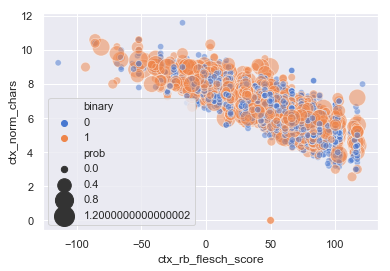

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = ctx_datasets_fc_context_complexity[0].train
complexity_plot_1 = sns.scatterplot(x="ctx_rb_flesch_score", y="ctx_norm_chars", 
                                    hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=data)
plt.show(complexity_plot_1)

## (4.3) Sentence/HIT features

import pickle

with open('resources/dbpedia-cache/dbpedia_annotations_00.json', 'rb') as fp:
    dbpedia_00 = pickle.load(fp)
    
with open('resources/dbpedia-cache/dbpedia_annotations_25.json', 'rb') as fp:
    dbpedia_25 = pickle.load(fp)
    
with open('resources/dbpedia-cache/dbpedia_annotations_50.json', 'rb') as fp:
    dbpedia_50 = pickle.load(fp)
    
with open('resources/dbpedia-cache/dbpedia_annotations_75.json', 'rb') as fp:
    dbpedia_75 = pickle.load(fp)
    
with open('resources/dbpedia-cache/pagerank.json', 'rb') as fp:
    page_rank = pickle.load(fp)

def overlaps(start1, end1, start2, end2):
    return bool(range(max(start1, start2), min(end1, end2)+1))

def dbp_match_entities(sentence, target, start, end, annotations):
    an_sents = annotations.get(sentence)
    if an_sents:
        ans = [(an['offset'], an['offset']+len(an['surfaceForm']), an) for an in an_sents]
        return [an for s, e, an in ans if overlaps(start, end, s, e)]
    return []

def dbp_pagerank(sentence, annotations):
    entities = annotations.get(sentence)
    if not entities:
        return 0
    return np.nan_to_num(np.mean([page_rank.get(entity['URI'], 0) for entity in entities]))

def ctx_features_sentence(dataframe, agg):
    df = dataframe.copy()
    df['dbp_pagerank_25'] = df.sentence.apply(lambda sentence : \
                                                dbp_pagerank(sentence, dbpedia_25))
    df = df.fillna(0)
    return df
    
ctx_fc_context_sentence = ContextFeatureCategory('context_complexity_sentence', \
                                ctx_features_sentence)
feature_categories.append(ctx_fc_context_sentence)

contexts = [ctx_sentence_nf]

ctx_datasets = [ContextDataset(ds.name, ctx, preprocess_ctx_df(ctx.func(ds.train)), 
                preprocess_ctx_df(ctx.func(ds.test)))
                for ctx in contexts
                for ds in datasets]

ctx_datasets_fc_context_complexity_sentence = [ContextFeatureDataset(ctx_ds.name, ctx_ds.context, 
        ctx_fc_context_sentence, agg, ctx_fc_context_sentence.func(ctx_ds.train, agg.agg),
        ctx_fc_context_sentence.func(ctx_ds.test, agg.agg))
        for ctx_ds in ctx_datasets for agg in aggs]

train = ctx_datasets_fc_context_complexity_sentence[0].train
train.loc[train.dbp_pagerank_25<30,]

concat = concat_feature_datasets(ctx_datasets_fc_context_complexity_sentence, ctx_datasets_fc_context_complexity)

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = concat[0].train
complexity_plot_1 = sns.scatterplot(x="ctx_norm_chars", y="dbp_pagerank_25", 
                                    hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=data)
plt.show(complexity_plot_1)

## 5. Evaluation

In [31]:
from collections import namedtuple
Result = namedtuple('Result', 'dataset, fc, agg, measure')
Dataset = namedtuple('Dataset', 'name, train, test')
FeatureDataset = namedtuple('FeatureDataset', 'name, fc, agg, train, test')
FeatureCategory = namedtuple('FeatureCategory', 'name, func')
Feature = namedtuple('Feature', 'name, fc_name, train, test')
Metric = namedtuple('Metric', 'name, func')

In [32]:
def remove_labels_for_binary_df(dataframe):
    df = dataframe.copy()
    df = df.drop(['id', 'sentence', 'target', 'nat', 'non_nat', 
                  'nat_marked', 'non_nat_marked', 'prob', 'start', 
                  'end', 'p_target', 'lemma', 'p_lemma', 'pos_tags', 'pos_tags_pt', 
                 'p_sentence', 'context', 'p_context_dist', 'p_context'], axis = 1)
    return df

def remove_label_for_binary_df_and_ctx_features(dataframe):
    df = remove_labels_for_binary_df(dataframe)
    df = df[df.columns.drop(list(df.filter(regex='ctx')))]
    df = df[df.columns.drop(list(df.filter(regex='rb_sybl_count_ratio')))]
    return df

def remove_labels_for_regr_df(dataframe):
    df = dataframe.copy()
    df = df.drop(['id', 'sentence', 'target', 'nat', 'non_nat', 
                  'nat_marked', 'non_nat_marked', 'binary', 'start', 
                  'end', 'p_target', 'lemma', 'p_lemma', 'pos_tags', 'pos_tags_pt',
                 'p_sentence', 'context', 'p_context_dist', 'p_context'], axis = 1)
    return df

    
def transform_feat_to_num(train, test):
    train_copy = train.copy()
    test_copy = test.copy()
    #train_copy = train_copy.replace(np.inf, 0)
    #train_copy = train_copy.replace(np.nan, 0)
    train_copy = train_copy.replace([np.inf, -np.inf], np.nan)
    train_copy = train_copy.fillna(0)
    #test_copy = test_copy.replace(np.inf, 0)
    #test_copy = test_copy.replace(np.nan, 0)
    test_copy = test_copy.replace([np.inf, -np.inf], np.nan)
    test_copy = test_copy.fillna(0)
    shape_train = train.shape
    shape_test = test.shape
    df = train_copy.append(test_copy, ignore_index=True)
    df = pd.get_dummies(df)
    return (df.loc[0:(shape_train[0]-1),], 
            df.loc[shape_train[0]:df.shape[0],])

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_fscore_support
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

def get_majority_class_prediction(train, test):
    dummy = DummyClassifier(strategy='most_frequent', 
                            random_state=None, constant=None)
    x_train = train.loc[:, train.columns != 'binary']
    y_train = train.binary.values
    x_test = test
    y_test = test.binary.values
    dummy.fit(x_train, y_train)
    prediction = dummy.predict(x_test)
    f1score = f1_score(y_test, prediction)
    return f1score

def always_complex_prediction(train, test):
    y_test = test.binary.values
    prediction = [1 for val in y_test]
    f1score = precision_recall_fscore_support(y_test, prediction)
    return f1score

def svm(train, test):
    print('average_classification')
    x_train = train.loc[:, train.columns != 'binary']
    y_train = train.binary.values
    x_test = test.loc[:, test.columns != 'binary']
    y_test = test.binary.values
    seed = 7
    #knn = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
     #  beta_1=0.9, beta_2=0.999, early_stopping=False,
    #   epsilon=1e-08, hidden_layer_sizes=(5, 100), learning_rate='constant',
    #   learning_rate_init=0.001, max_iter=200, momentum=0.9,
    #   nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
    #   solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
    #   warm_start=False)
    knn = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)
    knn.fit(x_train, y_train) 
    prediction = knn.predict(x_test)
    f1score = f1_score(y_test, prediction)
    #kfold = model_selection.KFold(n_splits=2, random_state=seed)
    #cv_results = model_selection.cross_val_score(knn, x_train, y_train, cv=kfold, scoring=make_scorer(f1_score))
    return f1score

def xgboost(train, test):
    x_train = train.loc[:, train.columns != 'binary']
    y_train = train.binary.values
    x_test = test.loc[:, test.columns != 'binary']
    y_test = test.binary.values
    xgtrain = xgb.DMatrix(x_train.values, label=y_train)
    xgtest = xgb.DMatrix(x_test.values, label=y_test)
    xg_test_x = xgb.DMatrix(x_test.values)
    param = {'max_depth': 30, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic',  'n_estimators':5000}
    evallist = [(xgtest, 'eval'), (xgtrain, 'train')]
    num_round = 70
    bst = xgb.train(param, xgtrain, num_round, evallist)
    prediction = bst.predict(xg_test_x)
    prediction_binary = list(map(lambda val: 1 if val>0.5 else 0, prediction))
    f1score = precision_recall_fscore_support(y_test, prediction_binary)
    return f1score

def random_forest(train, test):
    x_train = train.loc[:, train.columns != 'binary']
    y_train = train.binary.values
    x_test = test.loc[:, test.columns != 'binary']
    y_test = test.binary.values
    clf = RandomForestClassifier(max_depth=10, random_state=0, n_estimators=1800, \
                            verbose=1, min_samples_split=5, min_samples_leaf=4, bootstrap=False)
    clf.fit(x_train, y_train)
    prediction = clf.predict(x_test)
    prediction_binary = list(map(lambda val: 1 if val>0.5 else 0, prediction))
    f1score = precision_recall_fscore_support(y_test, prediction_binary)
    return f1score

# {'n_estimators': 1800,
#  'min_samples_split': 5,
#  'min_samples_leaf': 4,
#  'max_features': 'auto',
#  'max_depth': 10,
#  'bootstrap': False}

def xgboost_with_bst(train, test):
    x_train = train.loc[:, train.columns != 'binary']
    y_train = train.binary.values
    x_test = test.loc[:, test.columns != 'binary']
    y_test = test.binary.values
    xgtrain = xgb.DMatrix(x_train.values, label=y_train, feature_names=x_train.columns.values)
    xgtest = xgb.DMatrix(x_test.values, label=y_test, feature_names=x_test.columns.values)
    xg_test_x = xgb.DMatrix(x_test.values, feature_names=x_test.columns.values)
    param = {'max_depth': 30, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic',  'n_estimators':5000}
    evallist = [(xgtest, 'eval'), (xgtrain, 'train')]
    num_round = 70
    bst = xgb.train(param, xgtrain, num_round, evallist)
    prediction = bst.predict(xg_test_x)
    prediction_binary = list(map(lambda val: 1 if val>0.5 else 0, prediction))
    f1score = precision_recall_fscore_support(y_test, prediction_binary)
    return f1score, bst

def adaboost(train, test):
    x_train = train.loc[:, train.columns != 'binary']
    y_train = train.binary.values
    x_test = test.loc[:, test.columns != 'binary']
    y_test = test.binary.values
    adab = AdaBoostClassifier(base_estimator=None, n_estimators=5000, 
                          learning_rate=1.0, algorithm='SAMME.R',
                          random_state=None)
    adab.fit(x_train, y_train) 
    prediction = adab.predict(x_test)
    f1score = precision_recall_fscore_support(y_test, prediction)
    return f1score

In [34]:
ContextFeatureDataset = namedtuple('ContextFeatureDataset', 'name, context, fc, agg, train, test')
Result = namedtuple('Result', 'dataset, fc, agg, context, measure')

In [35]:
train = ctx_datasets_fc_context_complexity[0].train
test = ctx_datasets_fc_context_complexity[0].train
train = remove_label_for_binary_df_and_ctx_features(train)
test = remove_label_for_binary_df_and_ctx_features(test)
transform_feat_to_num(train, test)

(      binary  wn_synset_freq  wn_synset_avg_lemma_freq  \
 0          1            1.00                  5.000000   
 1          1           25.00                  4.360000   
 2          0           18.00                  3.000000   
 3          1            7.00                  1.857143   
 4          1            7.00                  1.785714   
 5          1            7.00                  1.714286   
 6          1            9.00                  3.555556   
 7          0            6.00                  1.666667   
 8          1            2.00                  1.000000   
 9          0            3.20                  1.413333   
 10         1            5.00                  3.400000   
 11         0            9.00                  2.666667   
 12         1            5.00                  3.600000   
 13         0           37.00                  3.972973   
 14         1            8.75                  2.108333   
 15         1           10.00                  1.611111 

In [ ]:
train

## (5.2.1) XGBoost Target Base Model

In [152]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
fs = ctx_datasets_fc_context_complexity[0]
train, test = transform_feat_to_num(remove_label_for_binary_df_and_ctx_features(fs.train), \
        remove_label_for_binary_df_and_ctx_features(fs.test))
x_train = train.loc[:, train.columns != 'binary']
y_train = train.binary.values
rf_random.fit(x_train, y_train)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 13.5min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [153]:
rf_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': False}

In [36]:
results = [Result(fs, fs.fc, fs.agg, fs.context,
    random_forest(*transform_feat_to_num(remove_label_for_binary_df_and_ctx_features(fs.train), 
        remove_label_for_binary_df_and_ctx_features(fs.test)))) for fs in ctx_datasets_fc_context_complexity[0:3]]

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:   26.0s finished
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.6s finished


In [37]:
evaluation = [{'dataset' : result.dataset.name, 'agg' : result.agg[0],
                    'zc' : result.fc, 'prec' : result.measure[0][1],
               'rec' : result.measure[1][1], 'f1' : result.measure[2][1]} 
                   for result in results]
feature_eval_data = pd.DataFrame.from_records(evaluation)

In [38]:
feature_eval_data

,agg,dataset,f1,prec,rec,zc
0,"(dist, <function agg_ctx_feat_num_distance at 0x000000FC01E1DEA0>)",Wikipedia,0.765292,0.739011,0.793510,"(context_complexity, [(context_complexity_from_target, <function ctx_features_context_complexity_from_target at 0x000000FC25B7FD90>), (context_complexity_from_context, <function ctx_features_conte..."
1,"(dist, <function agg_ctx_feat_num_distance at 0x000000FC01E1DEA0>)",WikiNews,0.789546,0.767380,0.813031,"(context_complexity, [(context_complexity_from_target, <function ctx_features_context_complexity_from_target at 0x000000FC25B7FD90>), (context_complexity_from_context, <function ctx_features_conte..."
2,"(dist, <function agg_ctx_feat_num_distance at 0x000000FC01E1DEA0>)",News,0.839523,0.819425,0.860632,"(context_complexity, [(context_complexity_from_target, <function ctx_features_context_complexity_from_target at 0x000000FC25B7FD90>), (context_complexity_from_context, <function ctx_features_conte..."


## (5.2.2) Adding Context Features

In [39]:
results = [Result(fs, fs.fc, fs.agg, fs.context,
    random_forest(*transform_feat_to_num(remove_labels_for_binary_df(fs.train), 
        remove_labels_for_binary_df(fs.test)))) for fs in ctx_datasets_fc_context_complexity]

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:   36.8s finished
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:   37.7s finished
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:   38.5s finished
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.3s f

In [40]:
evaluation = [{'dataset' : result.dataset.name, 'agg' : result.agg[0],
                    'zc' : result.fc, 'context':result.context , 'prec' : result.measure[0][1],
               'rec' : result.measure[1][1], 'f1' : result.measure[2][1]} 
                   for result in results]
feature_eval_data = pd.DataFrame.from_records(evaluation)
feature_eval_data

,agg,context,dataset,f1,prec,rec,zc
0,"(dist, <function agg_ctx_feat_num_distance at 0x000000FC01E1DEA0>)","[(ctx_window_pre_suc_n, {'n': 2, 'filtering': True}, <function <lambda> at 0x000000FC7A0AD620>), (ctx_window_pre_suc_n, {'n': 2, 'filtering': True}, <function <lambda> at 0x000000FC7A0AD620>)]",Wikipedia,0.764622,0.740331,0.790560,"(context_complexity, [(context_complexity_from_target, <function ctx_features_context_complexity_from_target at 0x000000FC25B7FD90>), (context_complexity_from_context, <function ctx_features_conte..."
1,"(dist, <function agg_ctx_feat_num_distance at 0x000000FC01E1DEA0>)","[(ctx_window_pre_suc_n, {'n': 2, 'filtering': True}, <function <lambda> at 0x000000FC7A0AD620>), (ctx_window_pre_suc_n, {'n': 2, 'filtering': True}, <function <lambda> at 0x000000FC7A0AD620>)]",WikiNews,0.789474,0.772358,0.807365,"(context_complexity, [(context_complexity_from_target, <function ctx_features_context_complexity_from_target at 0x000000FC25B7FD90>), (context_complexity_from_context, <function ctx_features_conte..."
2,"(dist, <function agg_ctx_feat_num_distance at 0x000000FC01E1DEA0>)","[(ctx_window_pre_suc_n, {'n': 2, 'filtering': True}, <function <lambda> at 0x000000FC7A0AD620>), (ctx_window_pre_suc_n, {'n': 2, 'filtering': True}, <function <lambda> at 0x000000FC7A0AD620>)]",News,0.838122,0.818057,0.859195,"(context_complexity, [(context_complexity_from_target, <function ctx_features_context_complexity_from_target at 0x000000FC25B7FD90>), (context_complexity_from_context, <function ctx_features_conte..."
3,"(dist, <function agg_ctx_feat_num_distance at 0x000000FC01E1DEA0>)","[(ctx_window_pre_suc_n, {'n': 3, 'filtering': True}, <function <lambda> at 0x000000FC7A0AD6A8>), (ctx_window_pre_suc_n, {'n': 3, 'filtering': True}, <function <lambda> at 0x000000FC7A0AD6A8>)]",Wikipedia,0.758226,0.736111,0.781711,"(context_complexity, [(context_complexity_from_target, <function ctx_features_context_complexity_from_target at 0x000000FC25B7FD90>), (context_complexity_from_context, <function ctx_features_conte..."
4,"(dist, <function agg_ctx_feat_num_distance at 0x000000FC01E1DEA0>)","[(ctx_window_pre_suc_n, {'n': 3, 'filtering': True}, <function <lambda> at 0x000000FC7A0AD6A8>), (ctx_window_pre_suc_n, {'n': 3, 'filtering': True}, <function <lambda> at 0x000000FC7A0AD6A8>)]",WikiNews,0.787795,0.771739,0.804533,"(context_complexity, [(context_complexity_from_target, <function ctx_features_context_complexity_from_target at 0x000000FC25B7FD90>), (context_complexity_from_context, <function ctx_features_conte..."
5,"(dist, <function agg_ctx_feat_num_distance at 0x000000FC01E1DEA0>)","[(ctx_window_pre_suc_n, {'n': 3, 'filtering': True}, <function <lambda> at 0x000000FC7A0AD6A8>), (ctx_window_pre_suc_n, {'n': 3, 'filtering': True}, <function <lambda> at 0x000000FC7A0AD6A8>)]",News,0.837307,0.817808,0.857759,"(context_complexity, [(context_complexity_from_target, <function ctx_features_context_complexity_from_target at 0x000000FC25B7FD90>), (context_complexity_from_context, <function ctx_features_conte..."
6,"(dist, <function agg_ctx_feat_num_distance at 0x000000FC01E1DEA0>)","[(ctx_window_pre_suc_n, {'n': 4, 'filtering': True}, <function <lambda> at 0x000000FC7A0AD730>), (ctx_window_pre_suc_n, {'n': 4, 'filtering': True}, <function <lambda> at 0x000000FC7A0AD730>)]",Wikipedia,0.758523,0.731507,0.787611,"(context_complexity, [(context_complexity_from_target, <function ctx_features_context_complexity_from_target at 0x000000FC25B7FD90>), (context_complexity_from_context, <function ctx_features_conte..."
7,"(dist, <function agg_ctx_feat_num_distance at 0x000000FC01E1DEA0>)","[(ctx_window_pre_suc_n, {'n': 4, 'filtering': True}, <function <lambda> at 0x000000FC7A0AD730>), (ctx_window_pre_suc_n, {'n': 4, 'filtering': True}, <function <lambda> at 0x000000FC7A0AD730>)]",WikiNews,0.787204,0.773224,0.801700,"(context_complexity, [(context_complexity_from_target, <function ctx_features_context_complexity_from_target at 0x000000FC25B7FD90>), (con